In [1]:
# Adicione isso junto com os outros imports
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

# bibliotecas para treino, teste e validação, modelo de regressão e avaliação do modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# bibliotecas para avaliação de desempenho dos modelos de classificação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone

In [2]:
BASE_PATH = "/kaggle/input/the-oxford-iii-t-pet-dataset/" 
IMAGES_PATH = os.path.join(BASE_PATH, "images/images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations/annotations")

IMG_SIZE = (128, 128)

In [3]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data_complete(folder_path, img_size=(128, 128)):
    X = []
    y_especie = [] # 0: Gato, 1: Cachorro
    y_raca = []
    
    print("Carregando imagens e extraindo raças...")
    
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                
                if filename[0].islower():
                    label = 1 
                else:
                    label = 0 
                
                breed = filename.rsplit('_', 1)[0]
                
                X.append(img.flatten())
                y_especie.append(label)
                y_raca.append(breed)
                
            except Exception as e:
                pass

    return np.array(X), np.array(y_especie), np.array(y_raca)

In [4]:
X, y, y_breed = load_data_complete(IMAGES_PATH, IMG_SIZE)

Carregando imagens e extraindo raças...


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np


print(f"Total de imagens: {len(X)}")
print(f"Exemplos de raças no dataset: {np.unique(y_breed)[:5]}")

le = LabelEncoder()
y_encoded = le.fit_transform(y_breed)

class_names = le.classes_
print(f"Total de Classes (Raças): {len(class_names)}")

Total de imagens: 7390
Exemplos de raças no dataset: ['Abyssinian' 'Bengal' 'Birman' 'Bombay' 'British_Shorthair']
Total de Classes (Raças): 37


In [6]:
# 3. Divisão Treino e Teste
# Stratify=y_encoded garante que teremos a mesma proporção de cada raça no treino e no teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (5912, 49152), Teste: (1478, 49152)


In [7]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt

# --- 4. FUNÇÕES DE EXTRAÇÃO (HOG e LBP) ---

def extract_hog_features(X, img_size):
    features_list = []
    print(f"   > Extraindo HOG de {len(X)} imagens...")
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        # Parâmetros otimizados
        f = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features_list.append(f)
    return np.array(features_list)

def extract_lbp_features(X, img_size, P=8, R=1):
    features_list = []
    print(f"   > Extraindo LBP de {len(X)} imagens...")
    n_bins = P + 2 
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        # Histograma normalizado
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        features_list.append(hist)
    return np.array(features_list)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV
import os
import time

# --- Scikit-Image (Para Texturas e Haralick) ---
# O erro aconteceu aqui. Precisamos importar graycomatrix e graycoprops explicitamente.
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

# --- Scipy (Para Assimetria/Skewness nos Momentos de Cor) ---
from scipy.stats import skew

# --- Scikit-Learn (Pré-processamento e Métricas) ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.manifold import LocallyLinearEmbedding  # Para o LLE
from sklearn.decomposition import PCA                # Caso precise do PCA
from sklearn.pipeline import make_pipeline

# --- Scikit-Learn (Classificadores Clássicos) ---
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# --- XGBoost (O Classificador Principal) ---
from xgboost import XGBClassifier

In [9]:

import numpy as np

# --- 1. EXTRAÇÃO DE TODAS AS 5 FEATURES (TREINO) ---
print("=== 1. Extraindo Features do TREINO (Megazord) ===")

# Features de Forma
X_train_hog = extract_hog_features(X_train, IMG_SIZE)

# Features de Textura
X_train_lbp = extract_lbp_features(X_train, IMG_SIZE)


# --- 2. CONCATENAÇÃO TREINO ---
print("   > Juntando tudo no vetor de Treino...")
X_train_full = np.hstack((
    X_train_hog, 
    X_train_lbp))


# --- 3. EXTRAÇÃO DE TODAS AS 5 FEATURES (TESTE) ---
print("\n=== 2. Extraindo Features do TESTE (Megazord) ===")

X_test_hog = extract_hog_features(X_test, IMG_SIZE)
X_test_lbp = extract_lbp_features(X_test, IMG_SIZE)

# --- 4. CONCATENAÇÃO TESTE ---
print("   > Juntando tudo no vetor de Teste...")
X_test_full = np.hstack((
    X_test_hog, 
    X_test_lbp
))

print(f"\nShape Final Monstruoso (Treino): {X_train_full.shape}")
# Deve dar algo em torno de (N_imagens, 8000+)

=== 1. Extraindo Features do TREINO (Megazord) ===
   > Extraindo HOG de 5912 imagens...
   > Extraindo LBP de 5912 imagens...
   > Juntando tudo no vetor de Treino...

=== 2. Extraindo Features do TESTE (Megazord) ===
   > Extraindo HOG de 1478 imagens...
   > Extraindo LBP de 1478 imagens...
   > Juntando tudo no vetor de Teste...

Shape Final Monstruoso (Treino): (5912, 8110)


In [10]:
from xgboost import XGBClassifier

# --- 4. CLASSIFICADOR (XGBoost) ---
print("4. Treinando XGBoost")

xgb_final = XGBClassifier(
    n_estimators=1000, 
    learning_rate=0.03, # Aprendizado mais fino
    max_depth=7,        # Um pouco mais profundo para capturar detalhes
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob', 
    num_class=37,            
    tree_method='hist',      
    device='cuda',           # GPU se disponível
    random_state=42,
    n_jobs=-1
)

xgb_final.fit(X_train_full, y_train)

print("Treinamento concluído.")

4. Treinando XGBoost
Treinamento concluído.


In [11]:
# --- 5. AVALIAÇÃO ---
y_pred_final = xgb_final.predict(X_test_full)

print(f"=== RESULTADO FINAL (TODAS FEATURES + LLE) ===")
print(f"Acurácia Global: {accuracy_score(y_test, y_pred_final):.2%}")
print(classification_report(y_test, y_pred_final, target_names=class_names))

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [01:12:59] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


=== RESULTADO FINAL (TODAS FEATURES + LLE) ===
Acurácia Global: 16.04%
                            precision    recall  f1-score   support

                Abyssinian       0.11      0.10      0.10        40
                    Bengal       0.08      0.07      0.08        40
                    Birman       0.13      0.12      0.13        40
                    Bombay       0.34      0.33      0.33        40
         British_Shorthair       0.24      0.28      0.26        40
              Egyptian_Mau       0.20      0.23      0.21        40
                Maine_Coon       0.26      0.23      0.24        40
                   Persian       0.24      0.40      0.30        40
                   Ragdoll       0.09      0.12      0.11        40
              Russian_Blue       0.09      0.10      0.09        40
                   Siamese       0.14      0.12      0.13        40
                    Sphynx       0.19      0.30      0.23        40
          american_bulldog       0.11      0

=== RESULTADO GERAL (37 RAÇAS) ===
Acurácia Global: 16.04%
(Note que o chute aleatório seria apenas 2.7%)

Relatório por Raça:
                            precision    recall  f1-score   support

                Abyssinian       0.11      0.10      0.10        40
                    Bengal       0.08      0.07      0.08        40
                    Birman       0.13      0.12      0.13        40
                    Bombay       0.34      0.33      0.33        40
         British_Shorthair       0.24      0.28      0.26        40
              Egyptian_Mau       0.20      0.23      0.21        40
                Maine_Coon       0.26      0.23      0.24        40
                   Persian       0.24      0.40      0.30        40
                   Ragdoll       0.09      0.12      0.11        40
              Russian_Blue       0.09      0.10      0.09        40
                   Siamese       0.14      0.12      0.13        40
                    Sphynx       0.19      0.30      0.2

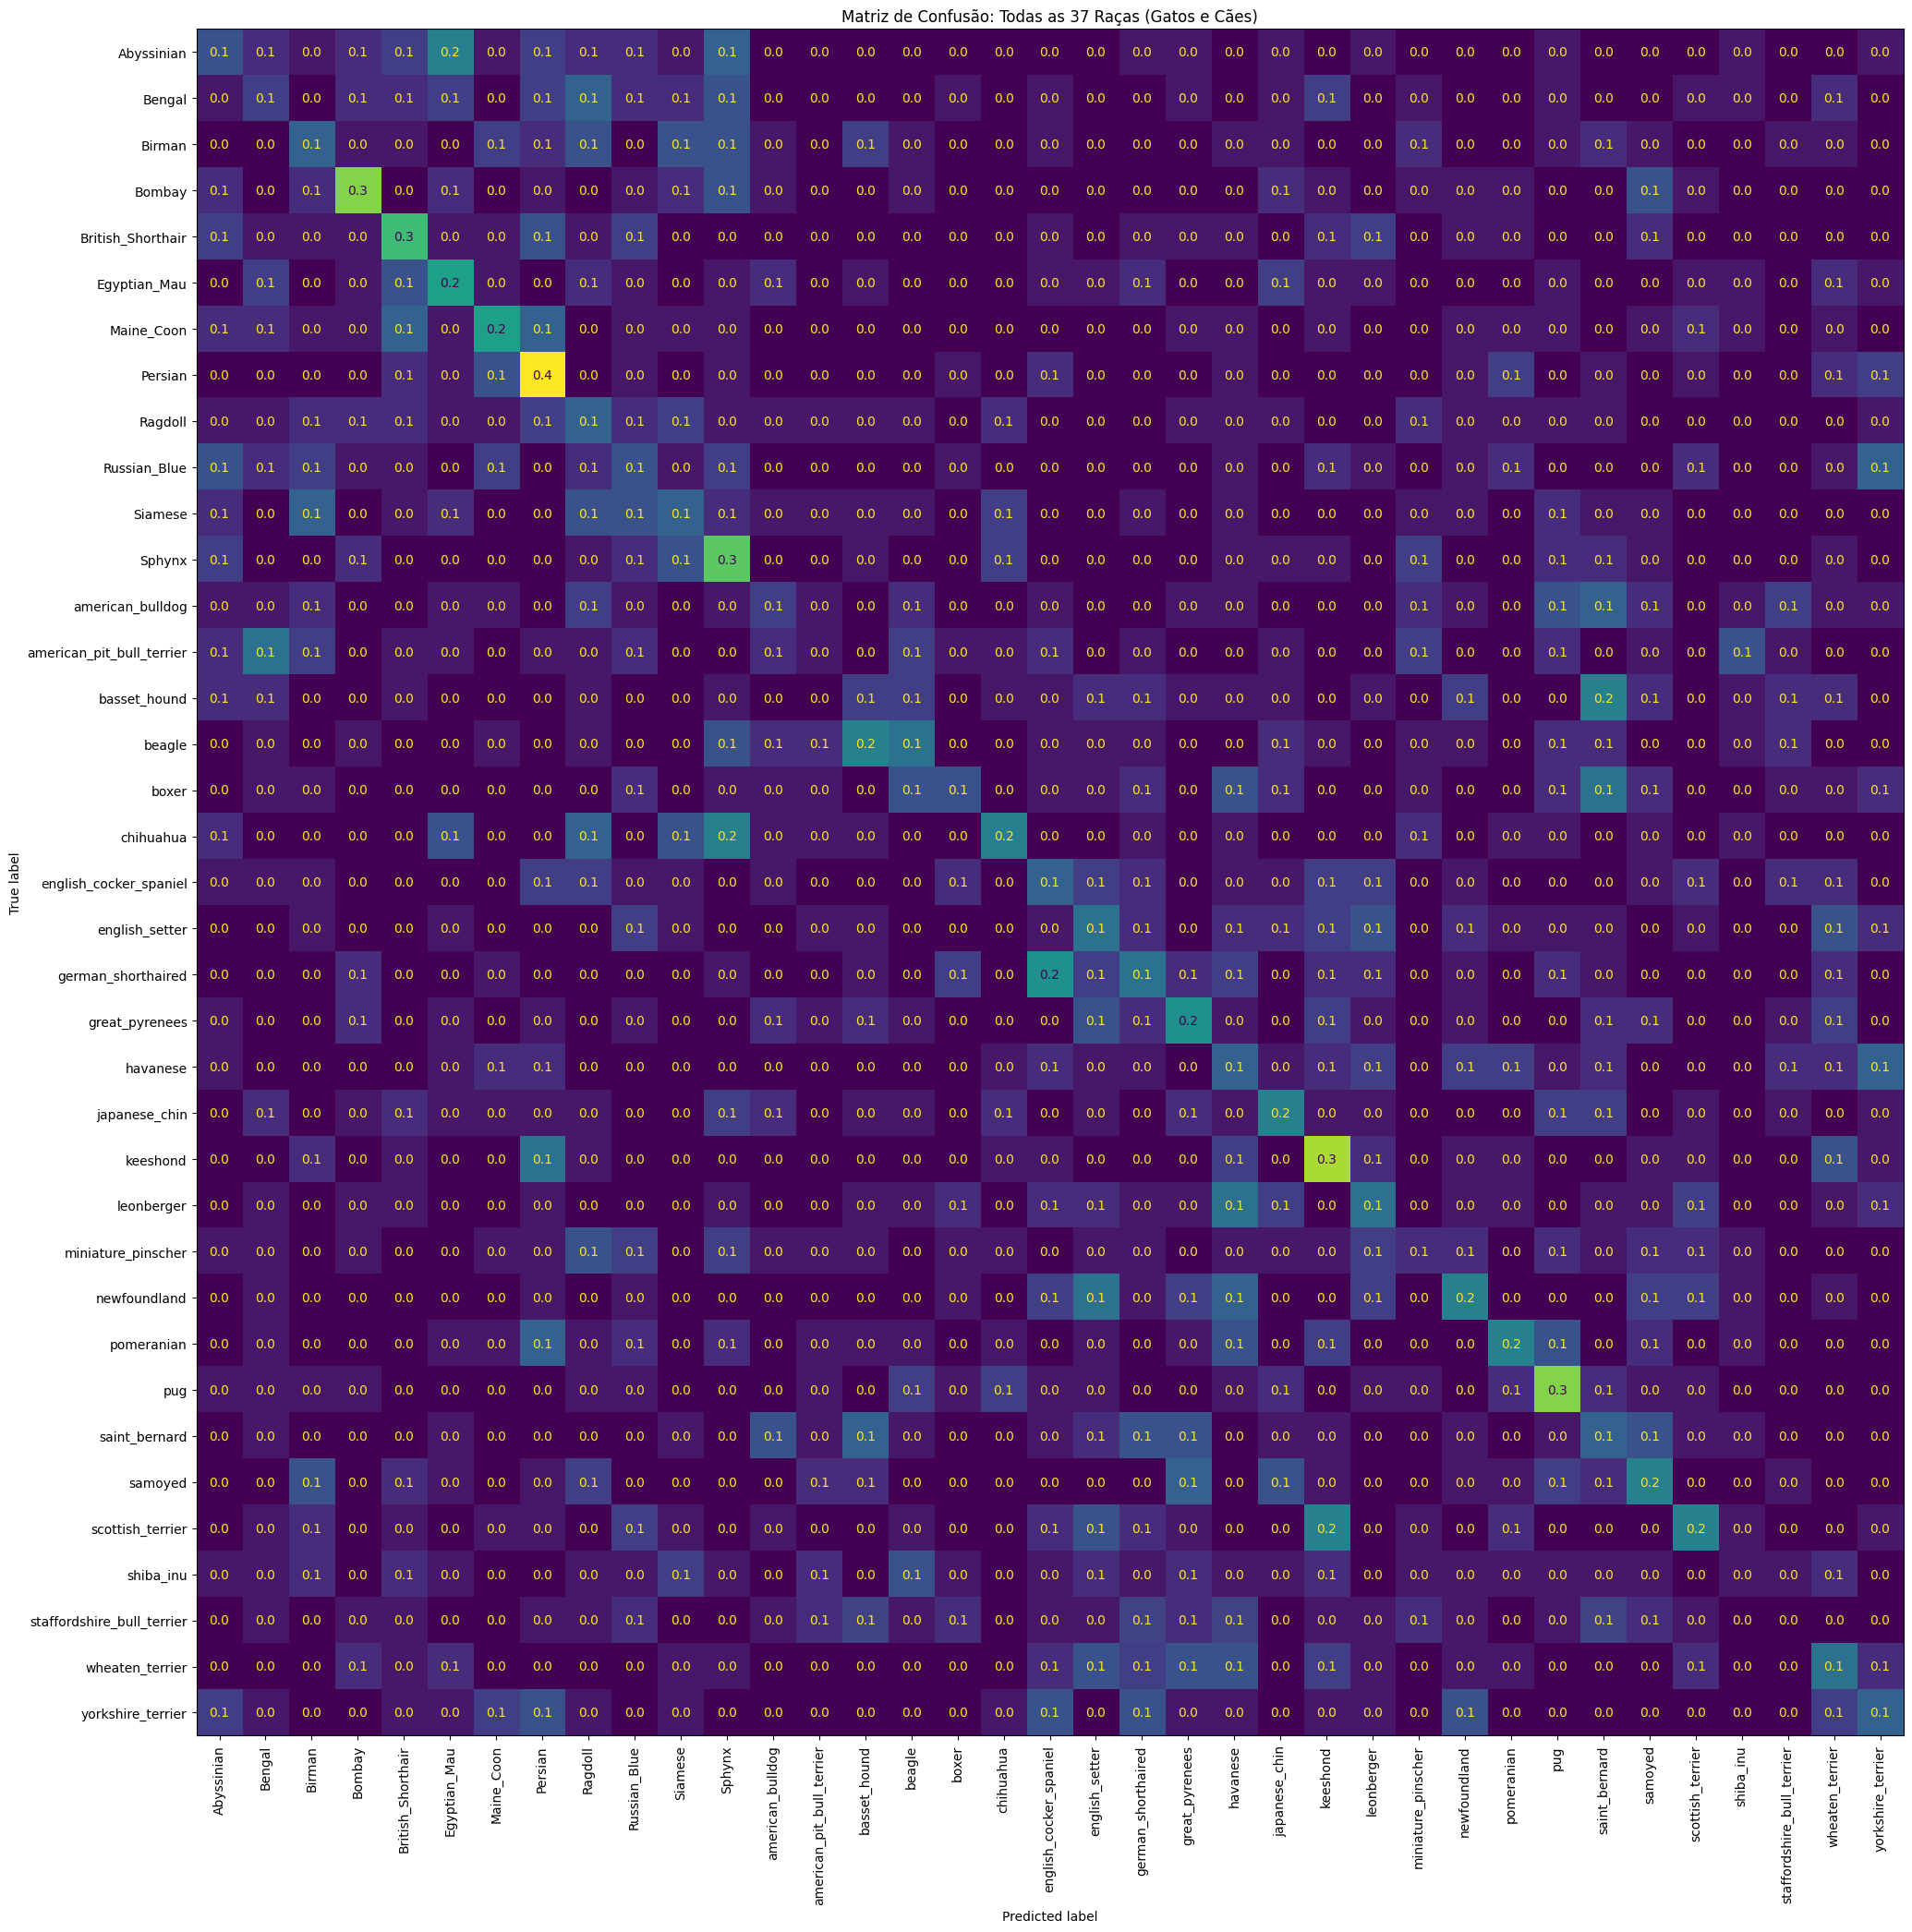

In [12]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# 1. Predição no Teste
y_pred_all = xgb_final.predict(X_test_full)

# 2. Acurácia Global
acc = accuracy_score(y_test, y_pred_all)
print(f"=== RESULTADO GERAL (37 RAÇAS) ===")
print(f"Acurácia Global: {acc:.2%}")
print("(Note que o chute aleatório seria apenas 2.7%)")

# 3. Relatório Detalhado (Precision/Recall por Raça)
# target_names coloca os nomes reais de volta
print("\nRelatório por Raça:")
print(classification_report(y_test, y_pred_all, target_names=class_names))

# 4. Matriz de Confusão (Normalizada)
# Define um tamanho de figura que comporte 37 raças
fig, ax = plt.subplots(figsize=(24, 24))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_all, 
    normalize="true",       # Mostra porcentagem de acerto
    display_labels=class_names, 
    cmap="viridis",         # Viridis ajuda a ver contrastes em muitas classes
    xticks_rotation='vertical',
    values_format=".1f",    # Uma casa decimal para não poluir
    ax=ax,
    colorbar=False
)

plt.title("Matriz de Confusão: Todas as 37 Raças (Gatos e Cães)")
plt.show()

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import FileLink, display  # Importação necessária para criar o link

# ==============================================================================
# GRÁFICO 1: RECALL (Normalizado por Linha)
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 20))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_all, 
    normalize="true",       
    display_labels=class_names, 
    cmap="viridis", 
    xticks_rotation='vertical',
    values_format=".1f",    
    ax=ax,
    colorbar=False
)

ax.set_title("Matriz de Confusão - Recall (Sensibilidade)", fontsize=20)
plt.tight_layout()

# Nome do arquivo
file_recall = "matriz_recall_xgb_hog_lbp.pdf"

# Salva na pasta de trabalho do Kaggle
plt.savefig(file_recall, format='pdf', bbox_inches='tight')
plt.close() # Fecha antes de criar o link para economizar memória

print(f"Arquivo gerado: {file_recall}")
# GERA O LINK PARA DOWNLOAD
display(FileLink(file_recall))

# ==============================================================================
# GRÁFICO 2: PRECISÃO (Normalizado por Coluna)
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 20))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_all, 
    normalize="pred",       
    display_labels=class_names, 
    cmap="magma",           
    xticks_rotation='vertical',
    values_format=".1f",
    ax=ax,
    colorbar=False
)

ax.set_title("Matriz de Confusão - Precisão (Confiança)", fontsize=20)
plt.tight_layout()

# Nome do arquivo
file_precisao = "matriz_precisao_xgb_hog_lbp.pdf"

# Salva na pasta de trabalho do Kaggle
plt.savefig(file_precisao, format='pdf', bbox_inches='tight')
plt.close()

print(f"Arquivo gerado: {file_precisao}")
# GERA O LINK PARA DOWNLOAD
display(FileLink(file_precisao))

Arquivo gerado: matriz_recall_xgb_hog_lbp.pdf


/kaggle/working/matriz_recall_xgb_hog_lbp.pdf

Arquivo gerado: matriz_precisao_xgb_hog_lbp.pdf


/kaggle/working/matriz_precisao_xgb_hog_lbp.pdf

In [14]:
# --- 5. AVALIAÇÃO ---
y_pred_final = xgb_final.predict(X_test_full)

print(f"=== RESULTADO FINAL (TODAS FEATURES + LLE) ===")
print(f"Acurácia Global: {accuracy_score(y_test, y_pred_final):.2%}")
print(classification_report(y_test, y_pred_final, target_names=class_names))

=== RESULTADO FINAL (TODAS FEATURES + LLE) ===
Acurácia Global: 16.04%
                            precision    recall  f1-score   support

                Abyssinian       0.11      0.10      0.10        40
                    Bengal       0.08      0.07      0.08        40
                    Birman       0.13      0.12      0.13        40
                    Bombay       0.34      0.33      0.33        40
         British_Shorthair       0.24      0.28      0.26        40
              Egyptian_Mau       0.20      0.23      0.21        40
                Maine_Coon       0.26      0.23      0.24        40
                   Persian       0.24      0.40      0.30        40
                   Ragdoll       0.09      0.12      0.11        40
              Russian_Blue       0.09      0.10      0.09        40
                   Siamese       0.14      0.12      0.13        40
                    Sphynx       0.19      0.30      0.23        40
          american_bulldog       0.11      0

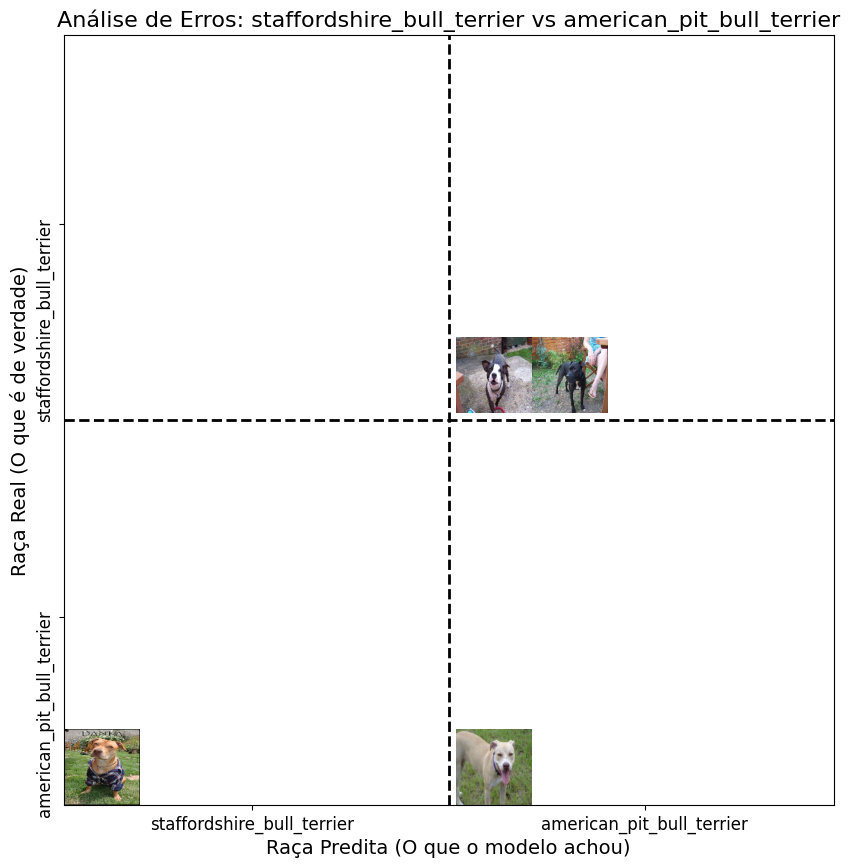

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_analysis(cl_a_name, cl_b_name, X_images, y_true, y_pred, label_encoder):
    """
    Plota uma matriz de imagens para analisar a confusão entre duas classes específicas.
    """
    
    # 1. Converter Nomes para IDs Numéricos
    try:
        # Pega o ID numérico correspondente ao nome da raça
        cl_a = list(label_encoder.classes_).index(cl_a_name)
        cl_b = list(label_encoder.classes_).index(cl_b_name)
    except ValueError:
        print(f"Erro: Raça não encontrada. Verifique os nomes em 'le.classes_'.")
        return

    # 2. Filtrar as Imagens para os 4 Cenários
    # X_aa: Era A, Predisse A (Acerto)
    X_aa = X_images[(y_true == cl_a) & (y_pred == cl_a)]
    
    # X_ab: Era A, Predisse B (Erro: Confundiu A com B)
    X_ab = X_images[(y_true == cl_a) & (y_pred == cl_b)]
    
    # X_ba: Era B, Predisse A (Erro: Confundiu B com A)
    X_ba = X_images[(y_true == cl_b) & (y_pred == cl_a)]
    
    # X_bb: Era B, Predisse B (Acerto)
    X_bb = X_images[(y_true == cl_b) & (y_pred == cl_b)]

    # 3. Configuração do Plot
    size = 5    # Número de imagens por linha/coluna em cada bloco
    pad = 0.2   # Espaçamento entre os blocos
    
    plt.figure(figsize=(10, 10))
    
    # Itera sobre os 4 blocos da matriz
    # A ordem dos blocos segue o código original do livro (Geron)
    # (0,0)=Canto Inf Esq | (1,0)=Canto Inf Dir | (0,1)=Canto Sup Esq | (1,1)=Canto Sup Dir
    for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                           (X_aa, (0, 1)), (X_ab, (1, 1))]:
        
        # Garante que não vamos tentar plotar mais imagens do que existem
        n_images = min(len(images), size * size)
        
        for idx in range(n_images):
            image_data = images[idx]
            
            # Define a posição x,y no grid geral
            x = (idx % size) + label_col * (size + pad)
            y = (idx // size) + label_row * (size + pad)
            
            # --- AJUSTE PARA SEU DATASET (COR) ---
            # Calcula o tamanho lateral (ex: sqrt(12288/3) = 64)
            side = int(np.sqrt(image_data.shape[0] / 3))
            
            # Reshape para (H, W, 3) para exibir cor
            img_reshaped = image_data.reshape(side, side, 3)
            
            # Normaliza para [0,1] se estiver em [0,255] (Matplotlib exige isso para floats)
            if img_reshaped.max() > 1:
                img_reshaped = img_reshaped.astype(float) / 255.0
            
            # Plota a imagem
            plt.imshow(img_reshaped, extent=(x, x + 1, y, y + 1))

    # 4. Decoração do Gráfico
    # Rótulos dos Eixos X e Y
    plt.xticks([size / 2, size + pad + size / 2], [cl_a_name, cl_b_name], fontsize=12)
    plt.yticks([size / 2, size + pad + size / 2], [cl_b_name, cl_a_name], fontsize=12, rotation=90)
    
    # Linhas Divisórias (A Cruz no meio)
    plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k--", linewidth=2)
    plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k--", linewidth=2)
    
    plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
    plt.xlabel("Raça Predita (O que o modelo achou)", fontsize=14)
    plt.ylabel("Raça Real (O que é de verdade)", fontsize=14)
    plt.title(f"Análise de Erros: {cl_a_name} vs {cl_b_name}", fontsize=16)
    
    plt.show()

# === COMO USAR ===

# 1. Escolha duas raças que apareceram "confusas" na sua Matriz de Confusão (os quadrados vermelhos fora da diagonal)
raca_A = "staffordshire_bull_terrier" # Substitua por nomes reais do seu dataset
raca_B = "american_pit_bull_terrier"

# 2. Chame a função
# IMPORTANTE: Passe 'X_test' (pixels originais), NÃO 'X_test_final' (features HOG/LBP)
# 'le' é o seu LabelEncoder usado anteriormente
plot_confusion_analysis(raca_A, raca_B, X_test, y_test, y_pred_all, le)